In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import igrins_mod as ig # Custom module file for igrins shenanigans

import glob
import os
import warnings

import astropy.units as u
from astropy.modeling import models
from astroquery.nist import Nist # atomic lines
# from astroquery.linelists.cdms import CDMS # molecular lines?

from lmfit import Model, Parameters
from lmfit.models import VoigtModel, LorentzianModel, SkewedGaussianModel, SkewedVoigtModel

from muler.igrins import IGRINSSpectrum, IGRINSSpectrumList

from tqdm import tqdm

from scipy.integrate import trapz, simpson
from scipy.signal import savgol_filter

from astropy.io import fits

# Plotting Parameters
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18

plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20

plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3

plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.minor.size'] = 5

plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.minor.size'] = 5

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

%matplotlib inline

In [1]:
%connect_info

{"key":"92357589-8fd3-43dd-bb5b-35726952d15d","signature_scheme":"hmac-sha256","transport":"tcp","ip":"127.0.0.1","hb_port":9024,"control_port":9025,"shell_port":9026,"stdin_port":9027,"iopub_port":9028,"kernel_name":"python390jvsc74a57bd0dd4343f90cc9aff75d4c277ea03d5ebdde6f6c86cd8ac1cae7529142cac067e3"}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing c:\Users\Savio\AppData\Roaming\jupyter\runtime\kernel-v3957cff20743dc282bdca715f06d842f1510d0de1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
# Size of 1 spectral resolution element
# IGRINS Spectral Resolution
spec_res = 0.00001

# Reduced and order-merged data filepath 
# Laptop Path
data_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-Spectra\\IGRINS_Merged"

# File path for figures to live in
fig_path = "C:\\Users\\Savio\\Documents\\GitHub\\IGRINS-SpectraIGRINS_figs\\standards_spectra"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
# merged_standard_files = glob.glob(data_path + "/merged_standards/m*.fits")
standard_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\standard_table_v3.txt', index_col=0)  # csv of standards with file and Spectral Type, c/v TBA
# just a pick a sequence of standards to look at: ["LkCa1","HBC427","Hubble4","Anon1","LkCa5","MHO8"])]
# Symposium sequence: ["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"]
standard_table = standard_table[standard_table['Name'].isin(["LkCa19","HBC427","Hubble4","Anon1","HBC359","LkCa21","LkCa1","MHO8"])].reset_index(drop=True)

proto_table = pd.read_csv('C:\\Users\\Savio\\Documents\\IGRINS-Spectra\\protostar_table.txt', index_col=0)

standards_path = standard_table['File']
standard_list = standard_table['File'].values

proto_path = proto_table['File']
proto_list = proto_table['File'].values

In [3]:
standard_stack = [] # initialize list of IGRINSSpectrum objects

for i in tqdm(range(len(standard_table))):
    spec_list = IGRINSSpectrumList.read(standards_path[i]).normalize().remove_nans()
    spec = spec_list.trim_edges().trim_overlap().stitch()

    standard_stack.append(spec)

# Determine the maximum length of flux arrays for the standards
max_flux_length = max(len(spec.flux.value) for spec in standard_stack)
max_wavelen_length = max(len(spec.wavelength.value) for spec in standard_stack)
max_snr_length = max(len(spec.snr.value) for spec in standard_stack)
max_unc_length = max(len(spec.uncertainty.array) for spec in standard_stack)

# Initialize stacks with NaN values
wavelen_stack = np.full((max_wavelen_length, len(standard_table)), np.nan)
flux_stack = np.full((max_flux_length, len(standard_table)), np.nan)
snr_stack = np.full((max_snr_length, len(standard_table)), np.nan)
flux_unc_stack = np.full((max_unc_length, len(standard_table)), np.nan)

wavemin = 2.07
wavemax = 2.35

for i in tqdm(range(len(standard_table))):
    # convert angstrom to micron
    wavelen = standard_stack[i].wavelength.value*1e-4
    flux = standard_stack[i].flux.value
    snr = standard_stack[i].snr.value
    raw_flux_err = standard_stack[i].uncertainty.array

    wavelen_mask = (wavelen > wavemin) & (wavelen < wavemax)
    flux_mask = (flux > 0)
    flux_snr_mask = (snr > 10)
    nan_mask = ~(np.isnan(wavelen))# & (~np.isnan(flux)) & (~np.isnan(snr))

    mask = (wavelen_mask) & (flux_mask) & (flux_snr_mask) #& (nan_mask)

    wavelen = wavelen[mask & nan_mask]
    flux = flux[mask & nan_mask]
    snr = snr[mask & nan_mask]
    raw_flux_err = raw_flux_err[mask & nan_mask]
    
    wavelen_stack[:len(wavelen),i] = wavelen
    flux_stack[:len(flux),i] = flux
    snr_stack[:len(snr),i] = snr
    flux_unc_stack[:len(raw_flux_err),i] = raw_flux_err

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 799.31it/s]


In [4]:
proto_stack = []
for i in tqdm(range(len(proto_table))):
    spec_list = IGRINSSpectrumList.read(proto_path[i]).normalize()
    spec = spec_list.trim_edges(limits=(150,1998)).normalize(order_index=14).trim_overlap().stitch()
    # spec = spec.remove_nans()
    proto_stack.append(spec)

# Determine the maximum length of flux arrays for the protostars
max_flux_length = max(len(spec.flux.value) for spec in proto_stack)
max_wavelen_length = max(len(spec.wavelength.value) for spec in proto_stack)
max_snr_length = max(len(spec.snr.value) for spec in proto_stack)
max_unc_length = max(len(spec.uncertainty.array) for spec in proto_stack)

# Initialize stacks with NaN values
# proto_wavelen_stack = np.full((max_wavelen_length, len(proto_table)), np.nan)
# proto_flux_stack = np.full((max_flux_length, len(proto_table)), np.nan)
# proto_snr_stack = np.full((max_snr_length, len(proto_table)), np.nan)
# proto_flux_unc_stack = np.full((max_unc_length, len(proto_table)), np.nan)

proto_wavelen_stack = []
proto_flux_stack = []
proto_snr_stack = []
proto_flux_unc_stack = []

wavemin=2.075
wavemax=2.35

symp_idxs = [7,13,23,25,33]
for i in tqdm(range(len(proto_table))):
    # convert angstrom to micron
    wavelen = proto_stack[i].wavelength.value*1e-4
    flux = proto_stack[i].flux.value # flux in counts
    snr = proto_stack[i].snr.value # SNR
    raw_flux_err = proto_stack[i].uncertainty.array # uncertainty

    wavelen_mask = (wavelen > wavemin) & (wavelen < wavemax) & (~np.isnan(wavelen))
    flux_mask = (flux > 0) & (~np.isnan(flux))
    flux_snr_mask = (snr > 0) & (~np.isnan(snr))

    mask = (wavelen_mask) & (flux_mask) & (flux_snr_mask)

    wavelen = wavelen[mask]
    flux = flux[mask]
    snr = snr[mask]
    raw_flux_err = raw_flux_err[mask]


    proto_wavelen_stack.append(wavelen)
    proto_flux_stack.append(flux)
    proto_snr_stack.append(snr)
    proto_flux_unc_stack.append(raw_flux_err)

    # proto_wavelen_stack[:len(wavelen),i] = wavelen
    # proto_flux_stack[:len(flux),i] = flux
    # proto_snr_stack[:len(snr),i] = snr
    # proto_flux_unc_stack[:len(raw_flux_err),i] = raw_flux_err

100%|█████████████████████████████████████████████████████████████████████████████████| 49/49 [00:00<00:00, 979.28it/s]


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

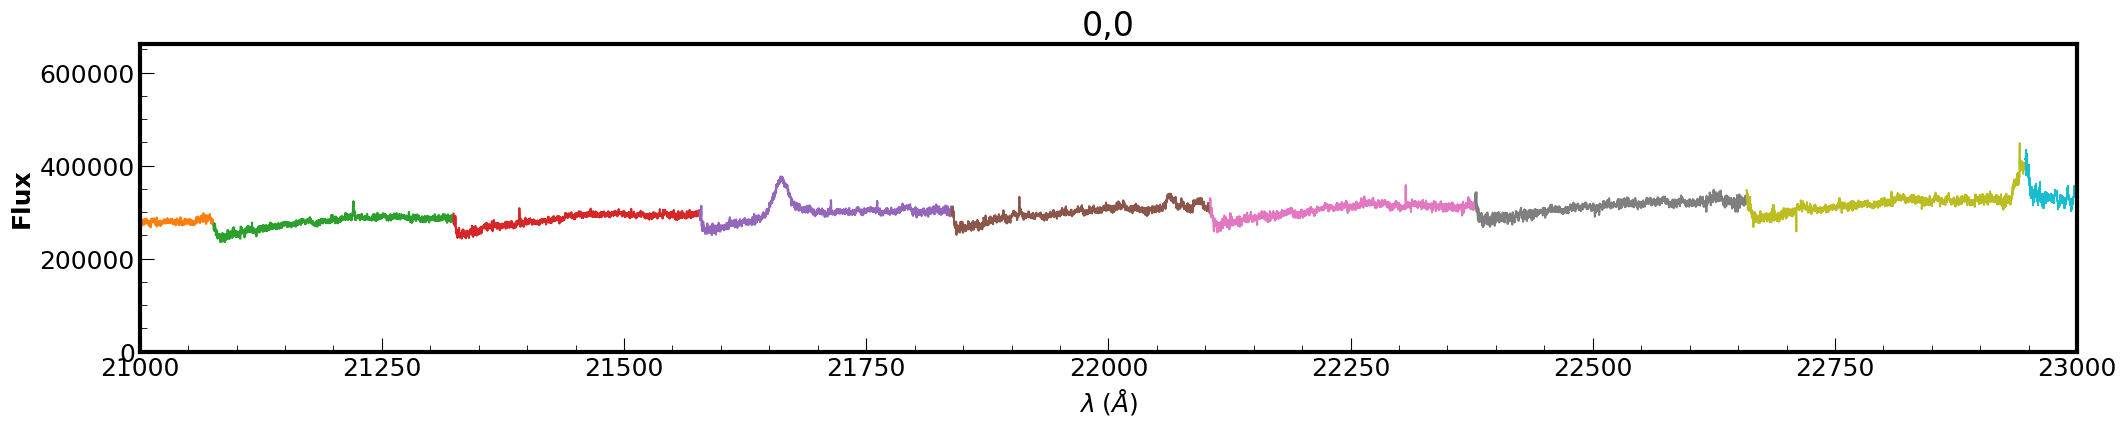

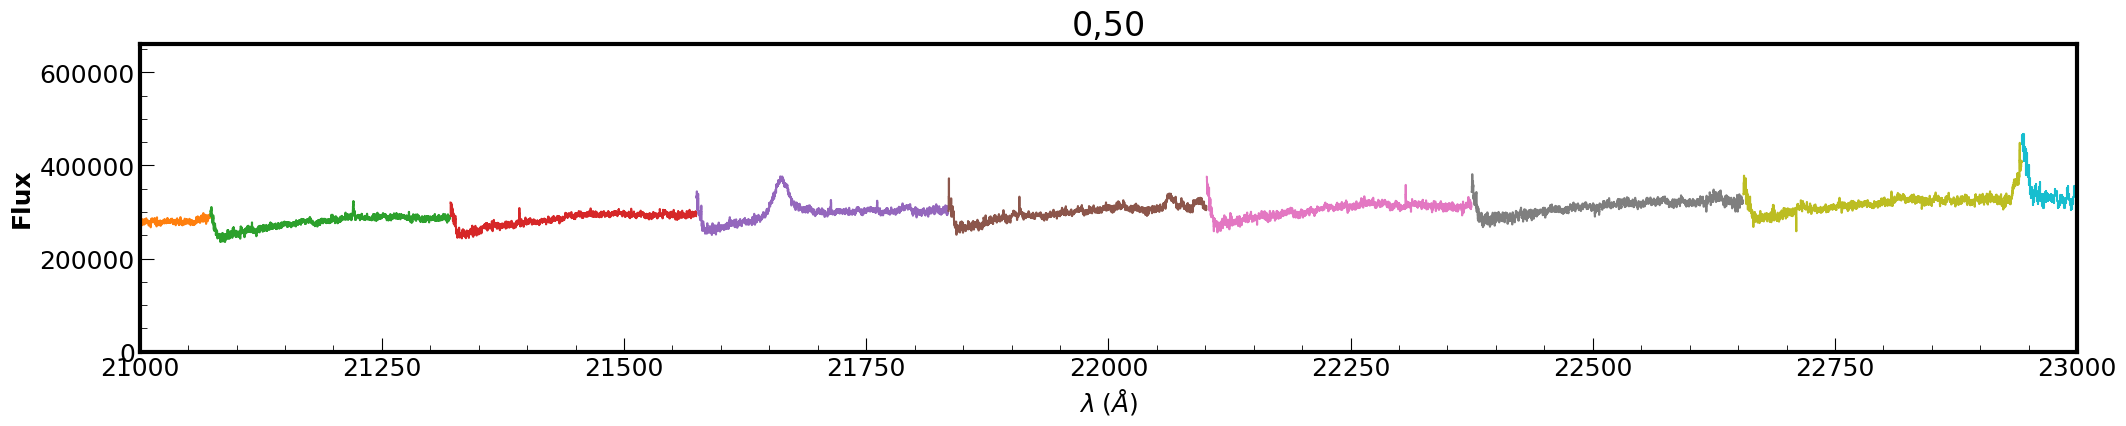

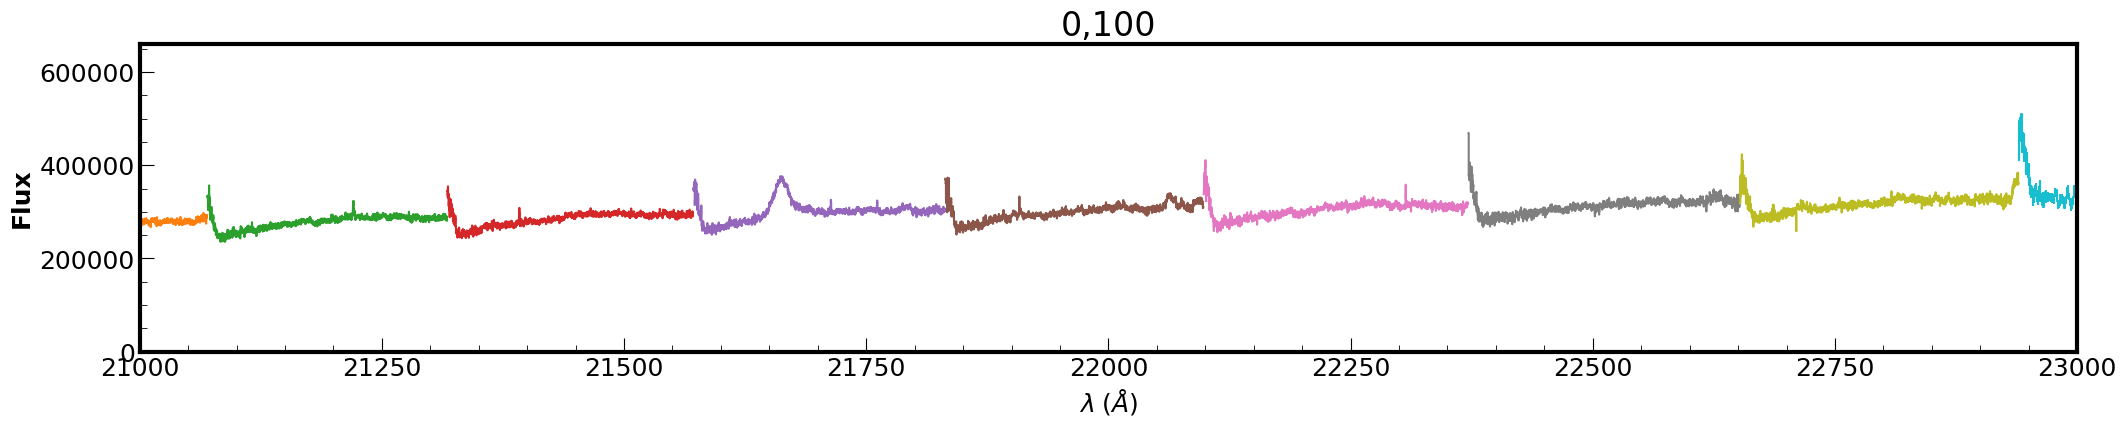

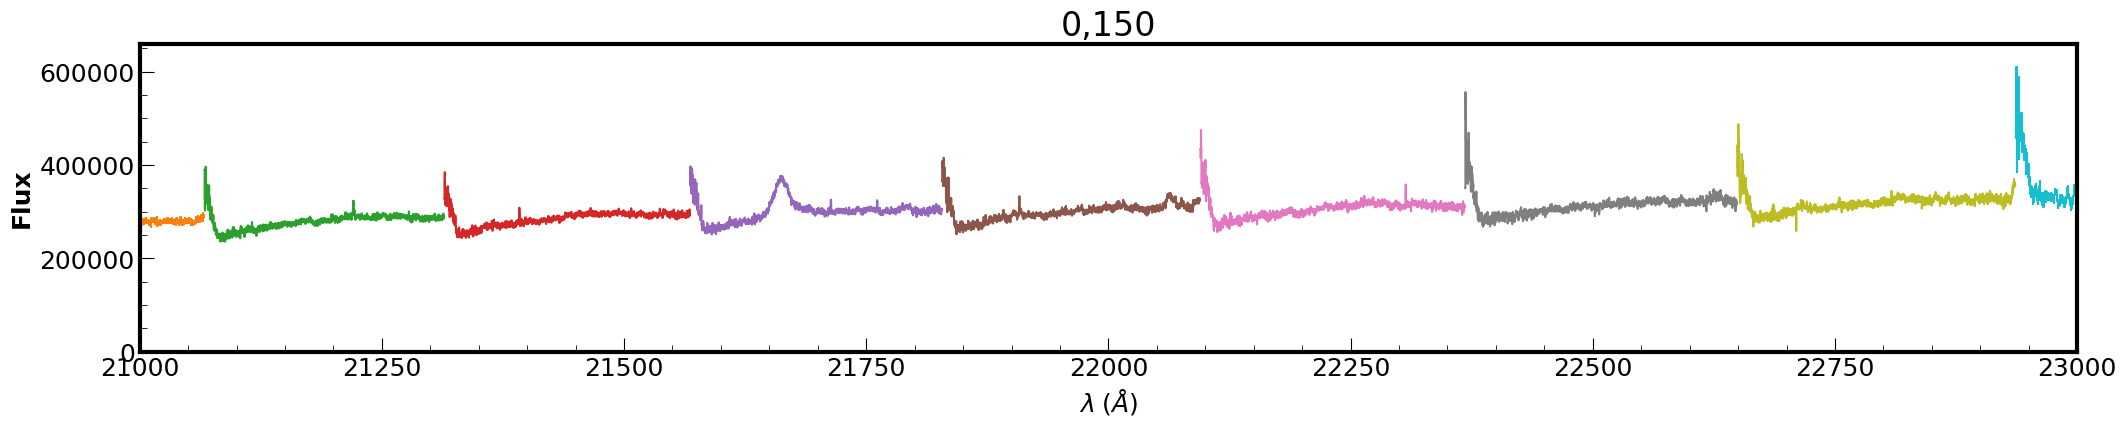

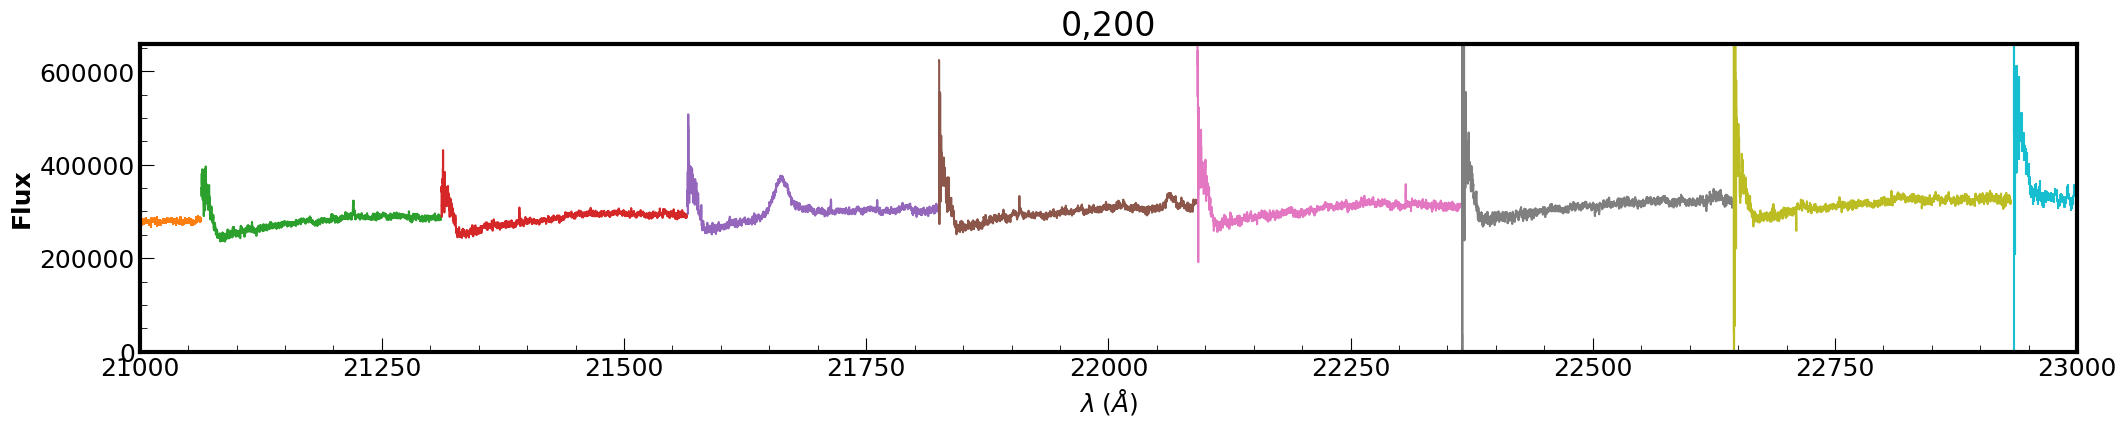

 20%|████████████████▊                                                                   | 1/5 [00:03<00:12,  3.23s/it]

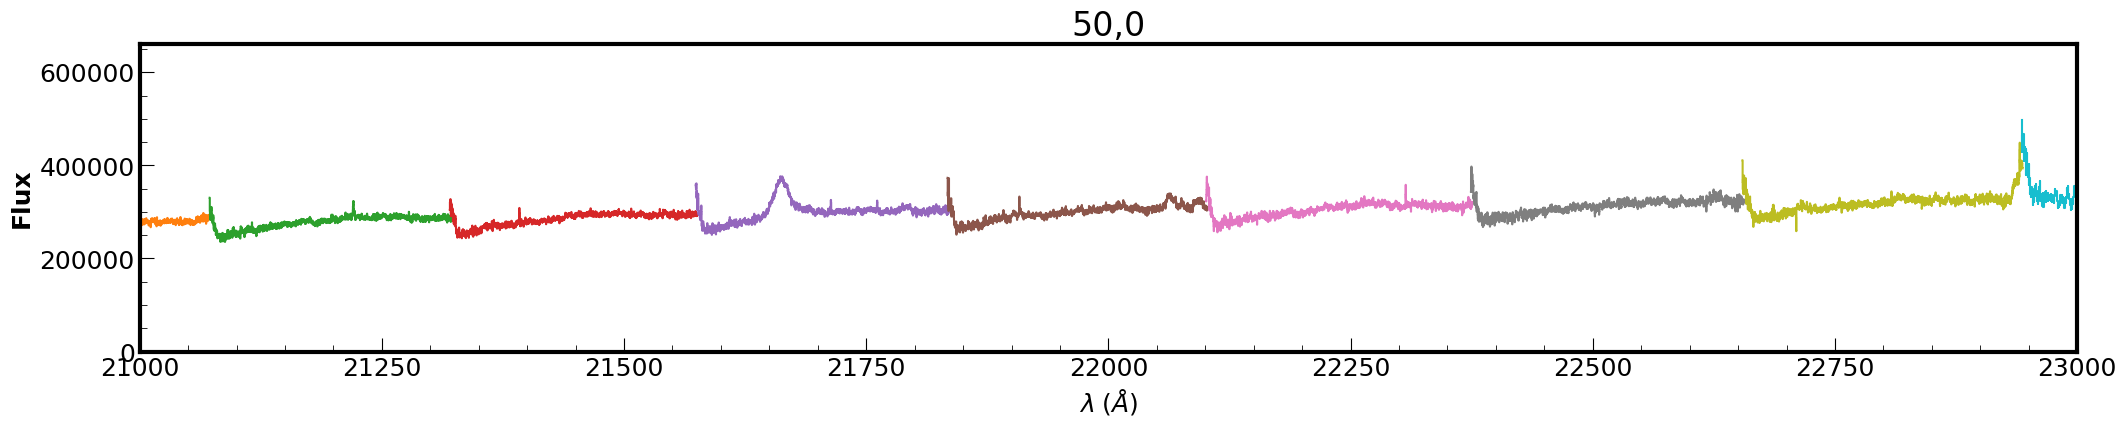

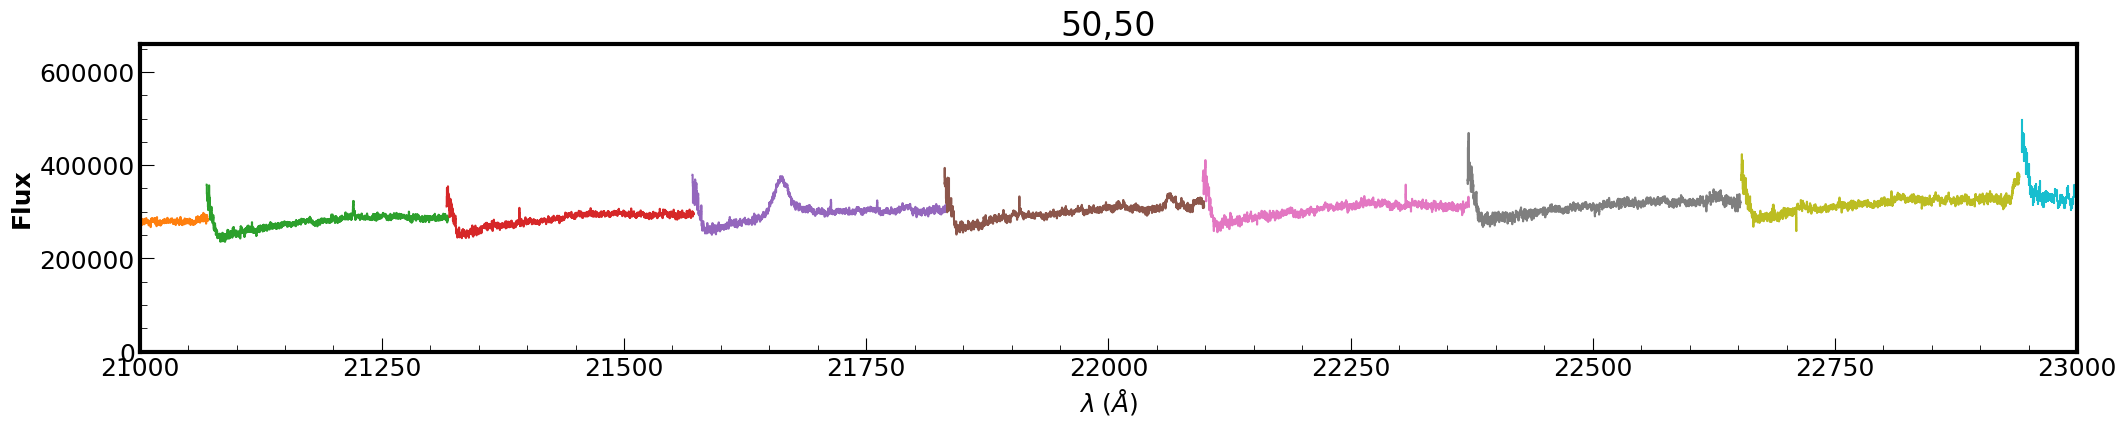

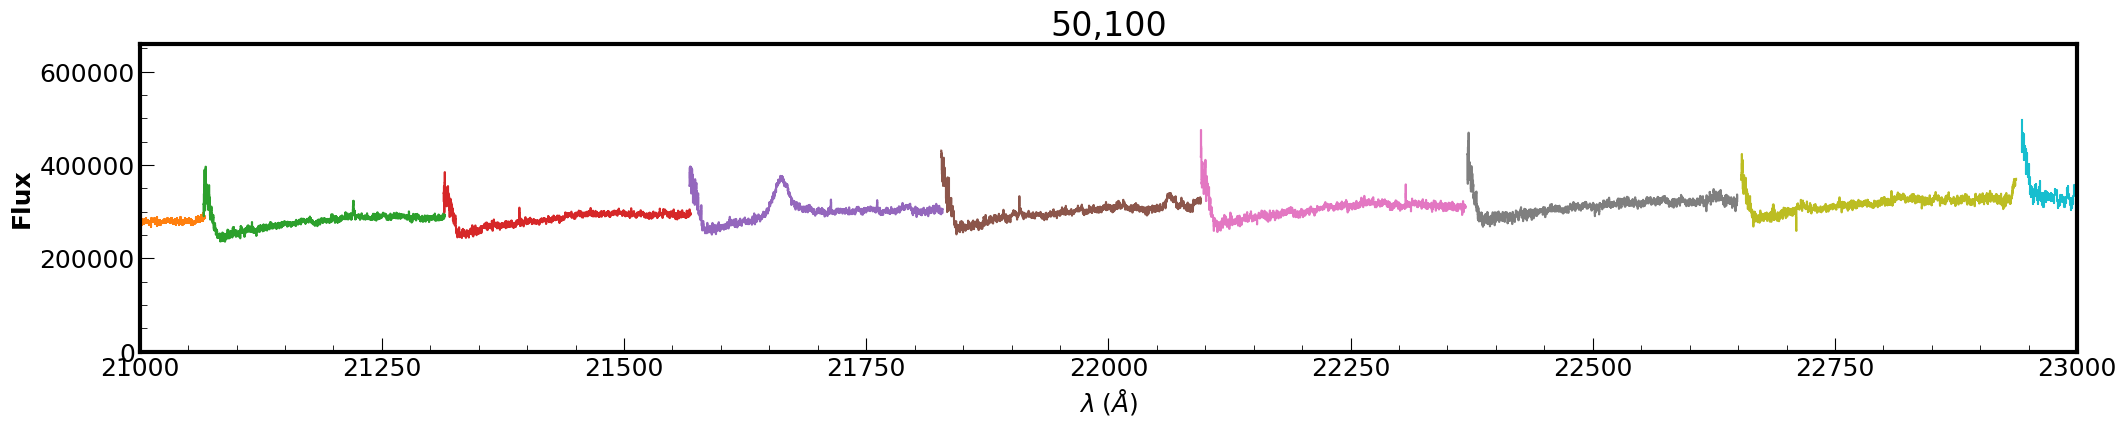

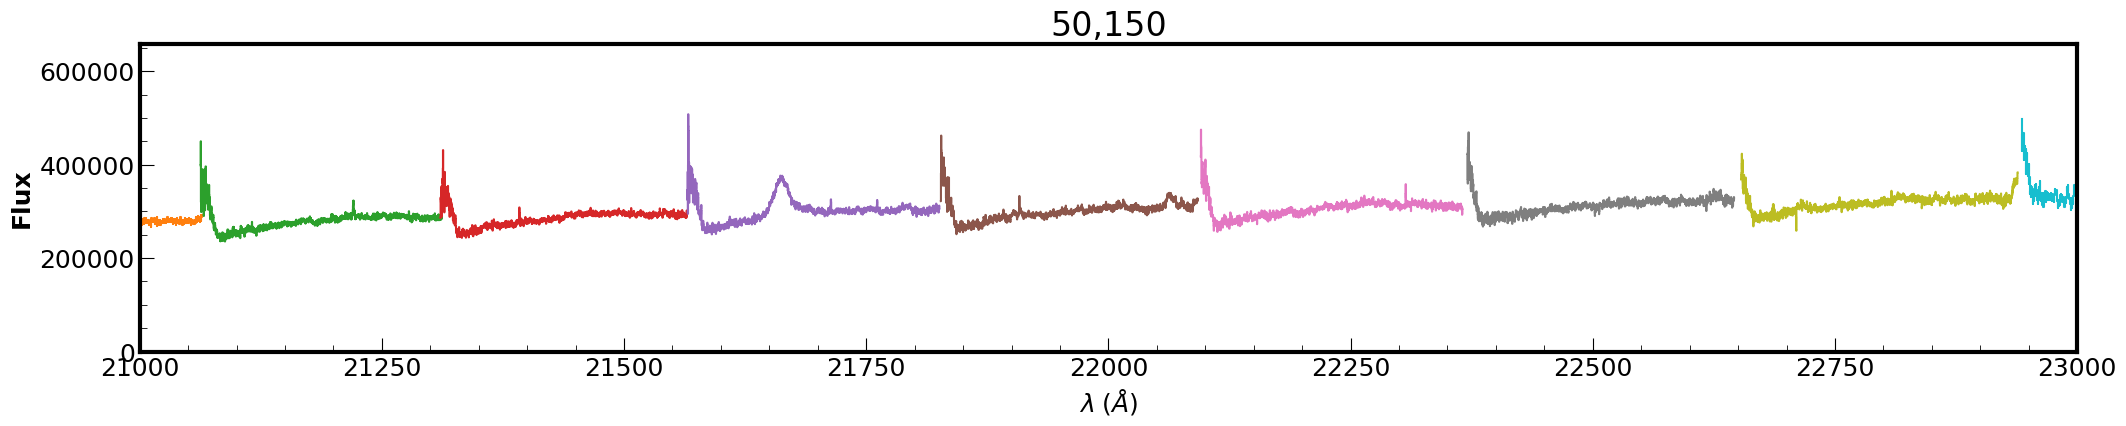

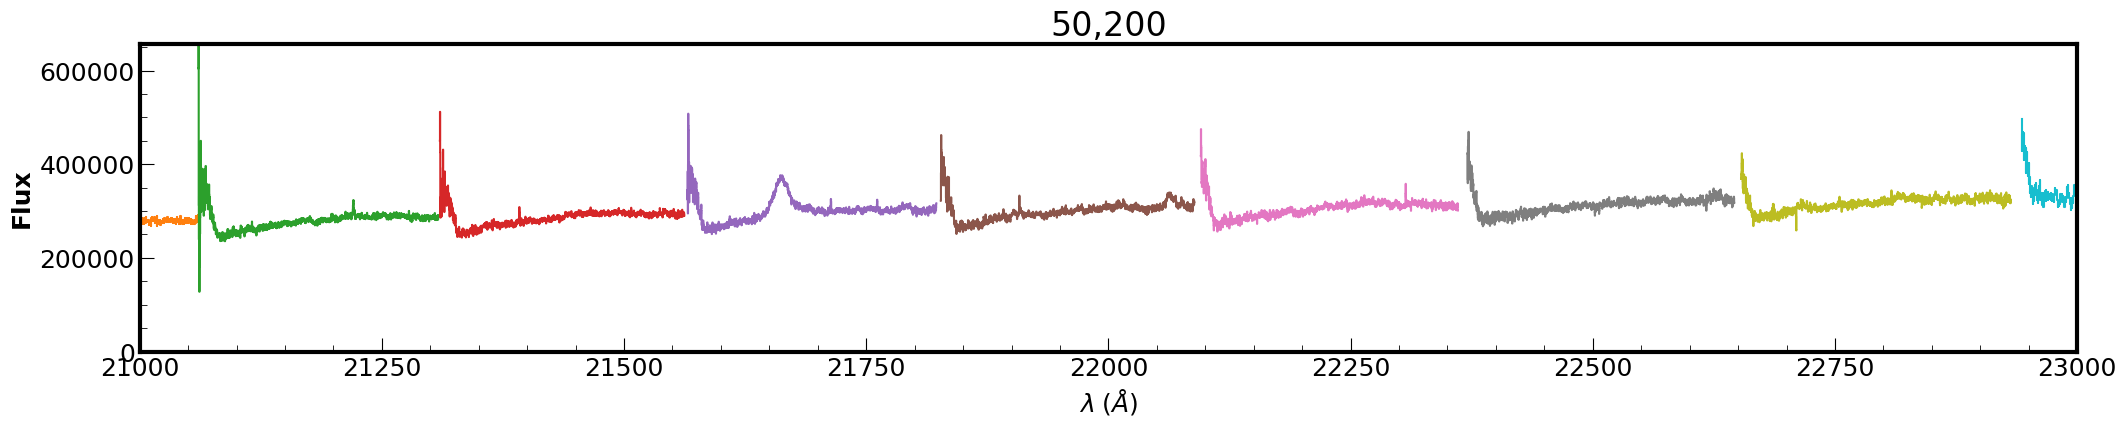

 40%|█████████████████████████████████▌                                                  | 2/5 [00:06<00:09,  3.01s/it]

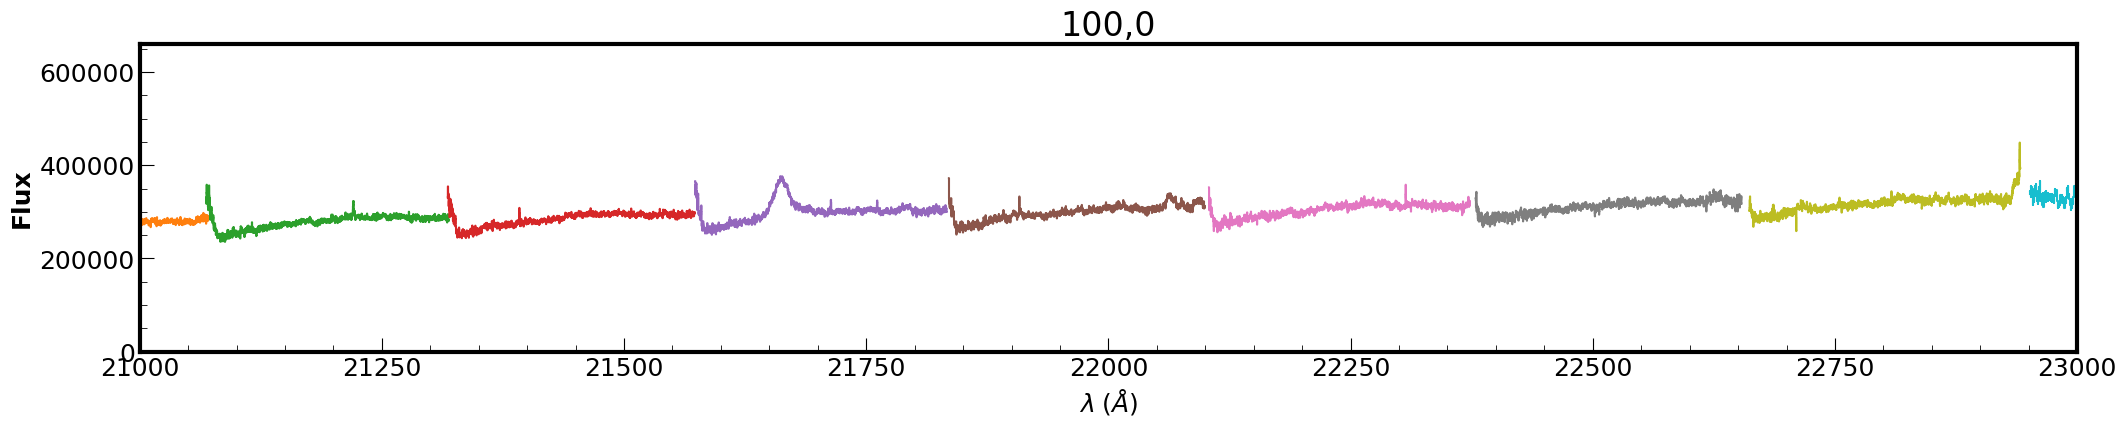

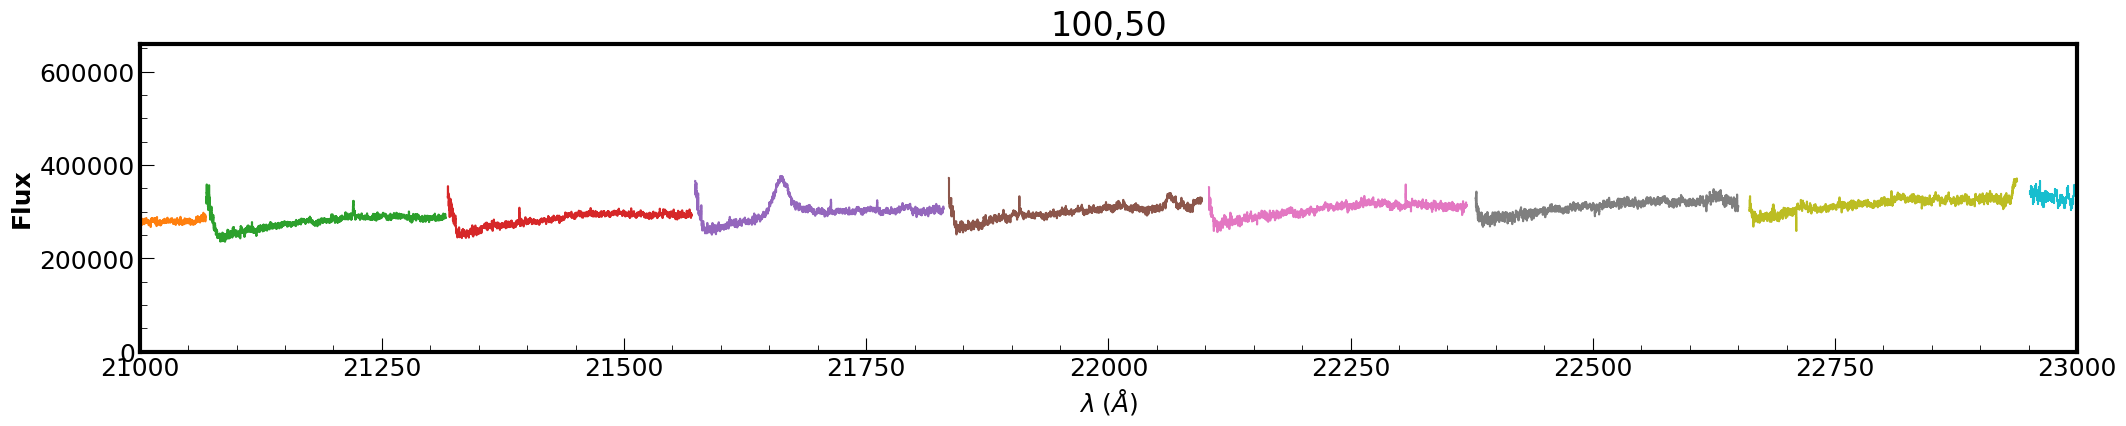

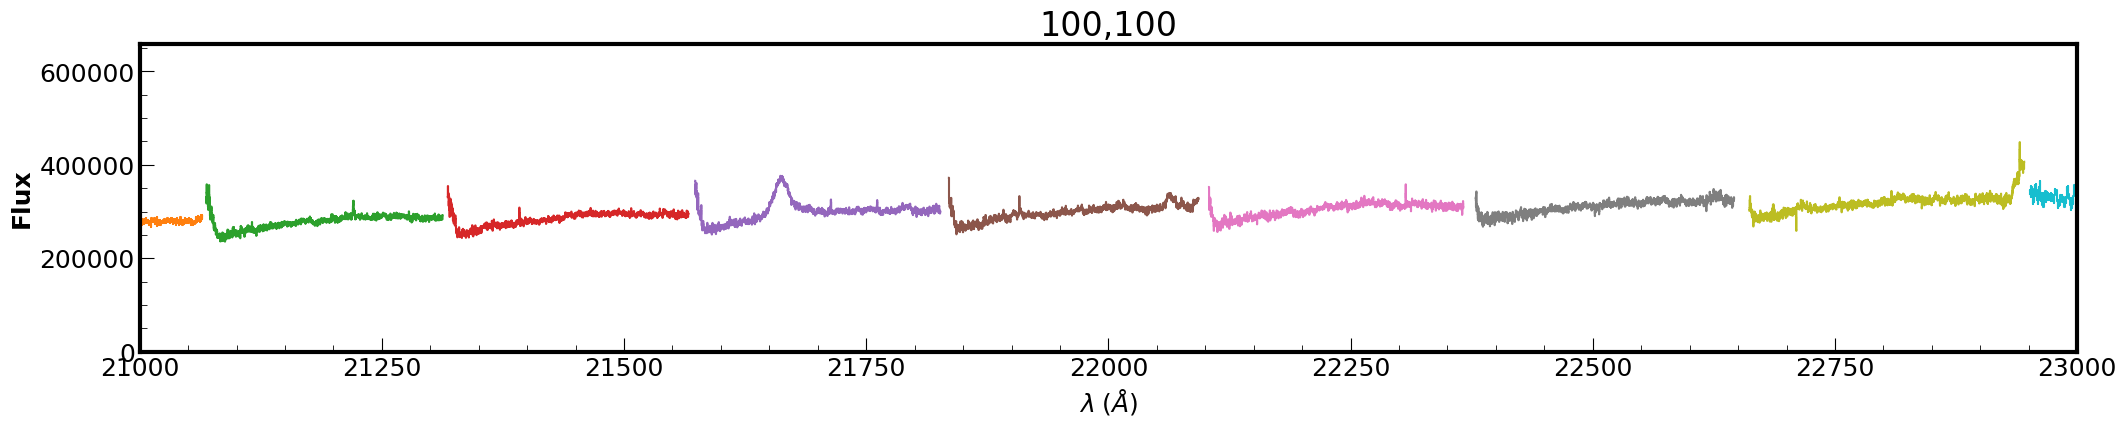

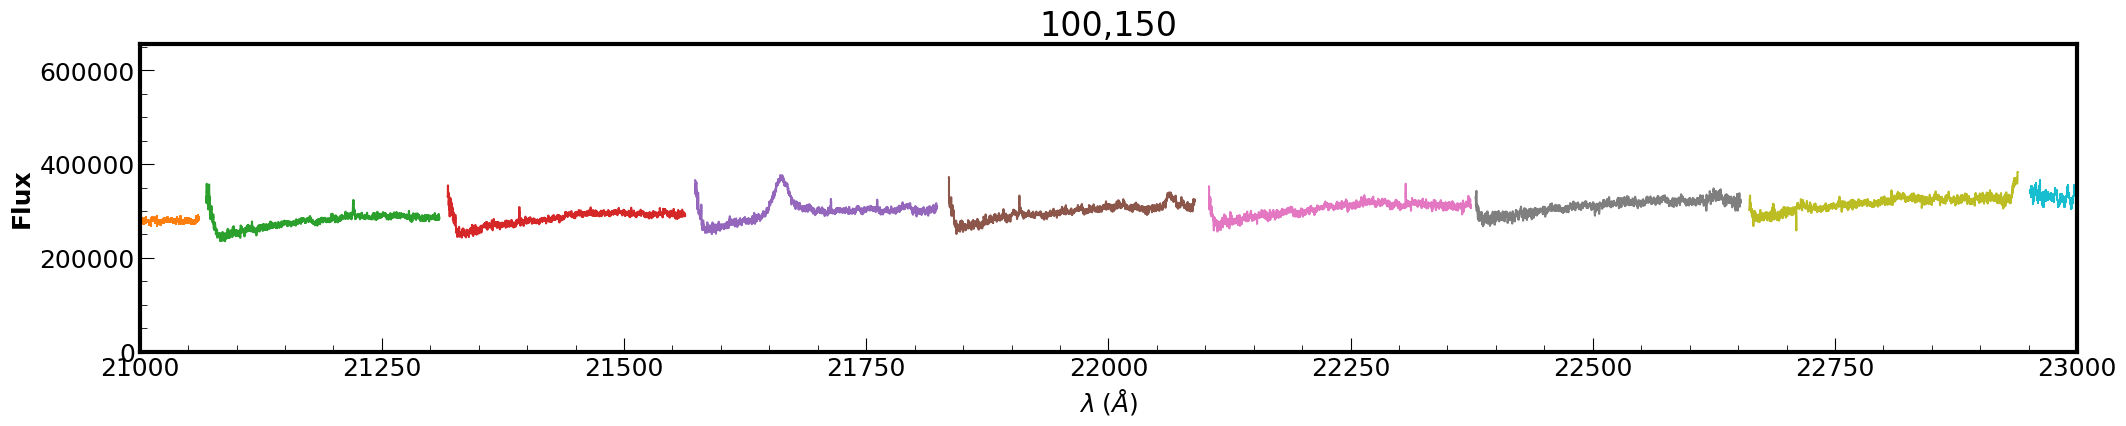

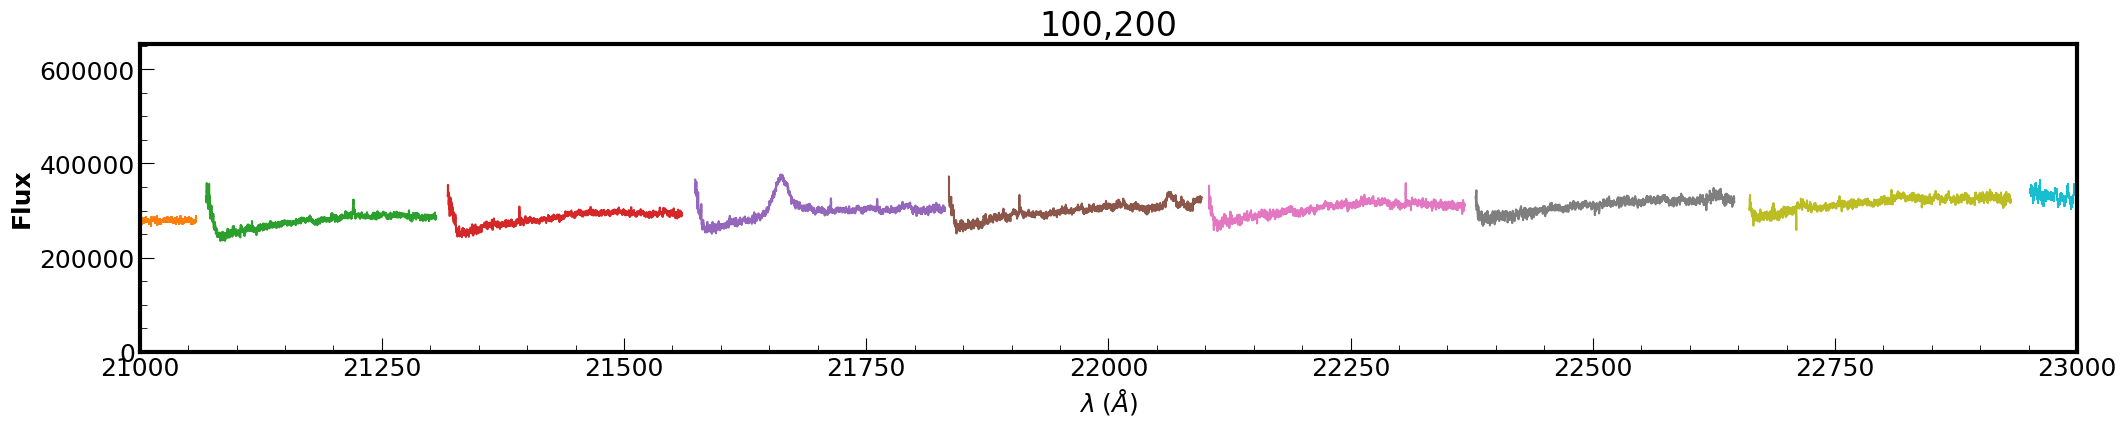

 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:09<00:06,  3.03s/it]

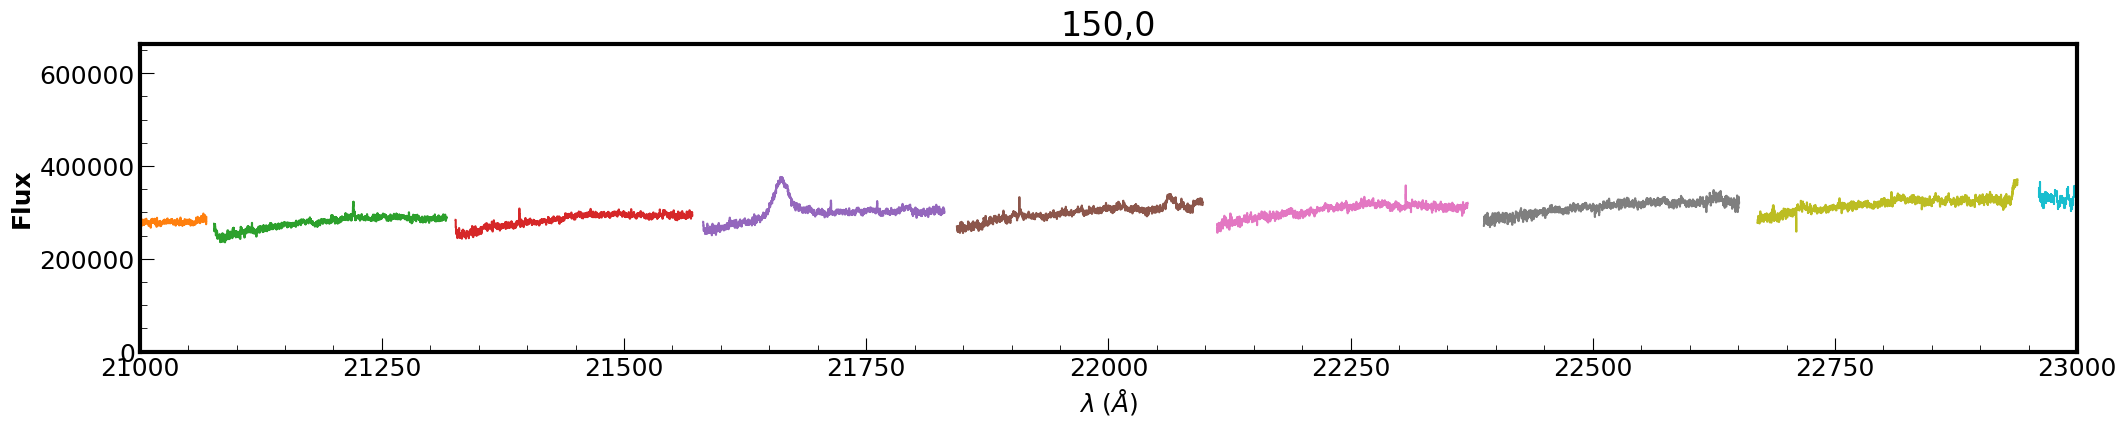

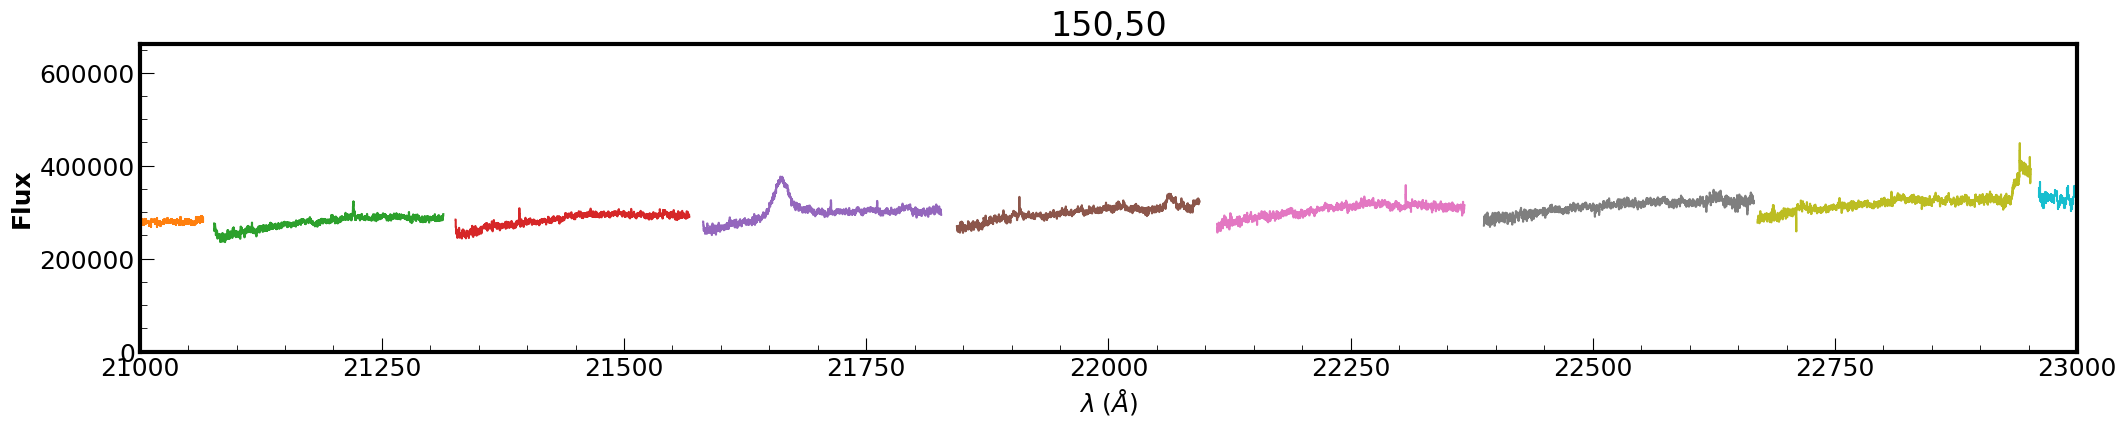

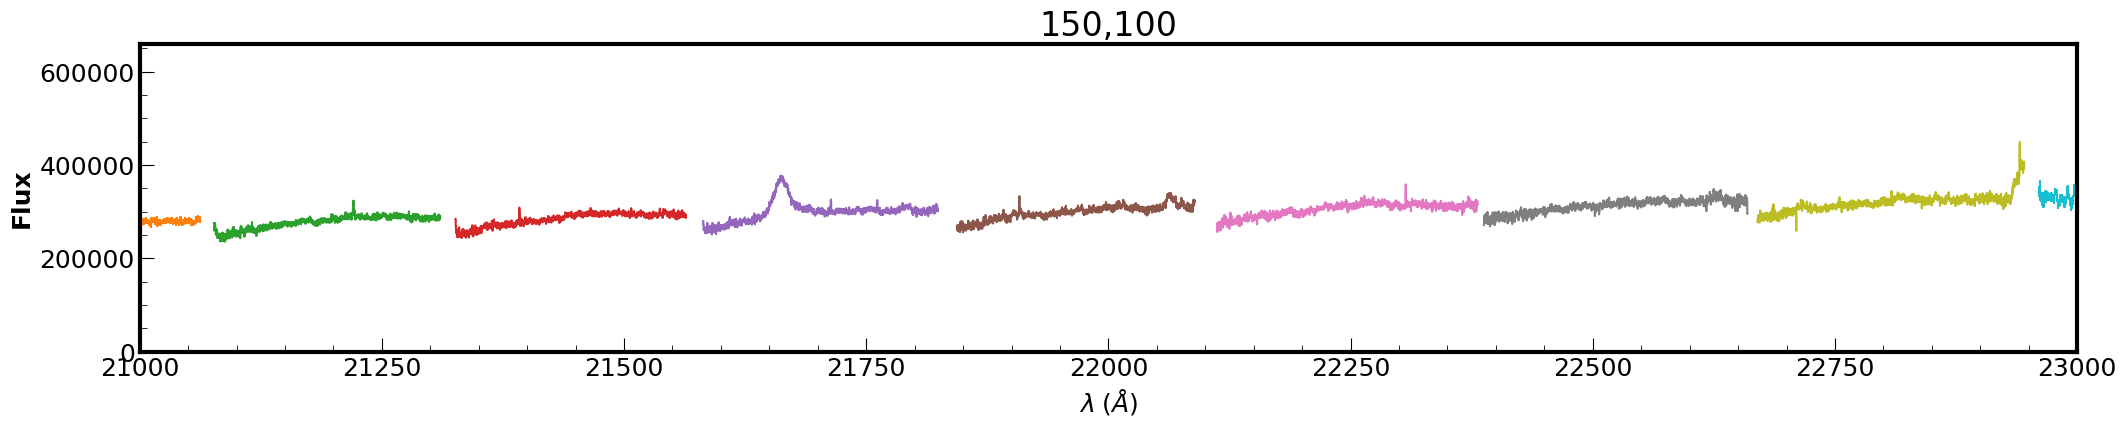

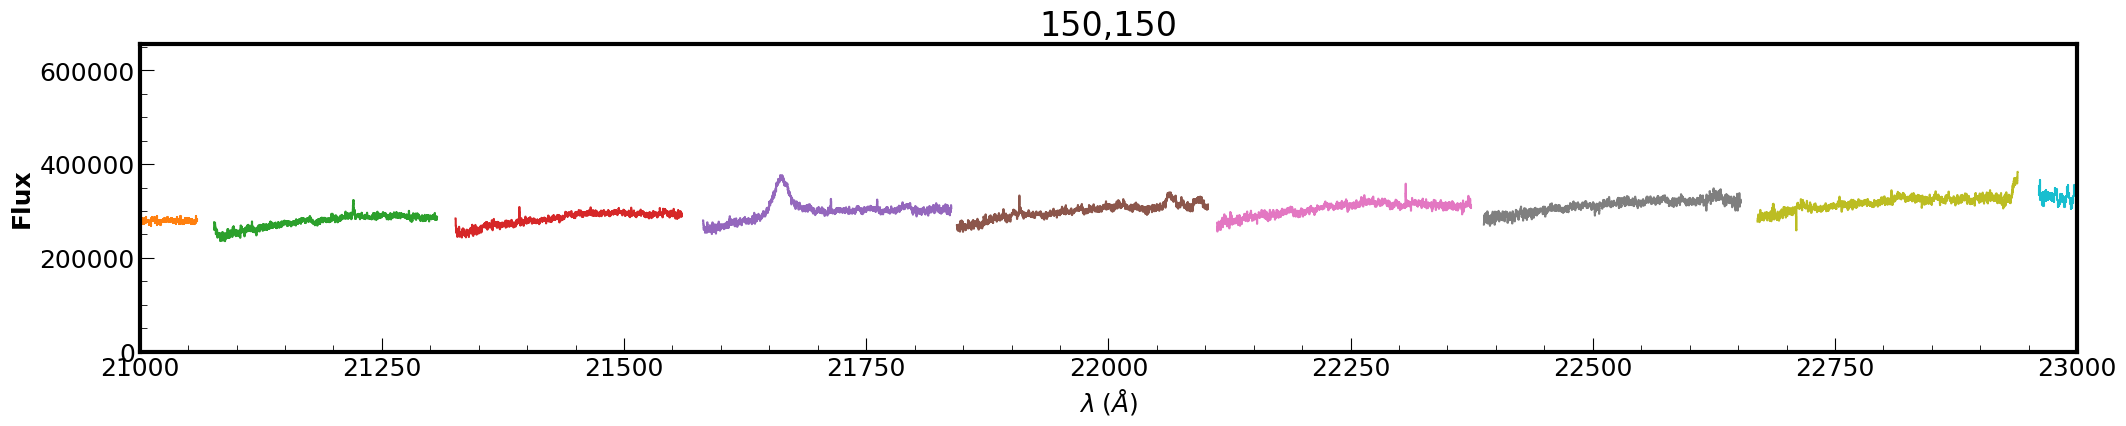

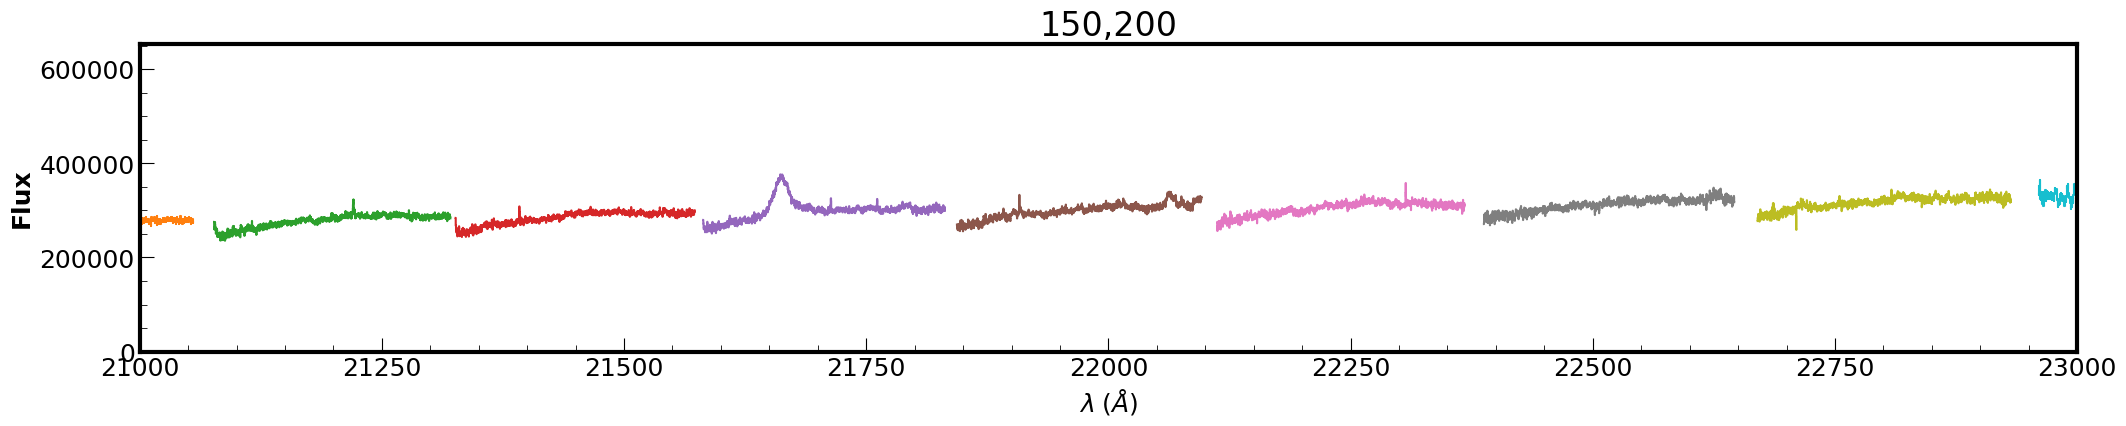

 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:12<00:03,  3.24s/it]

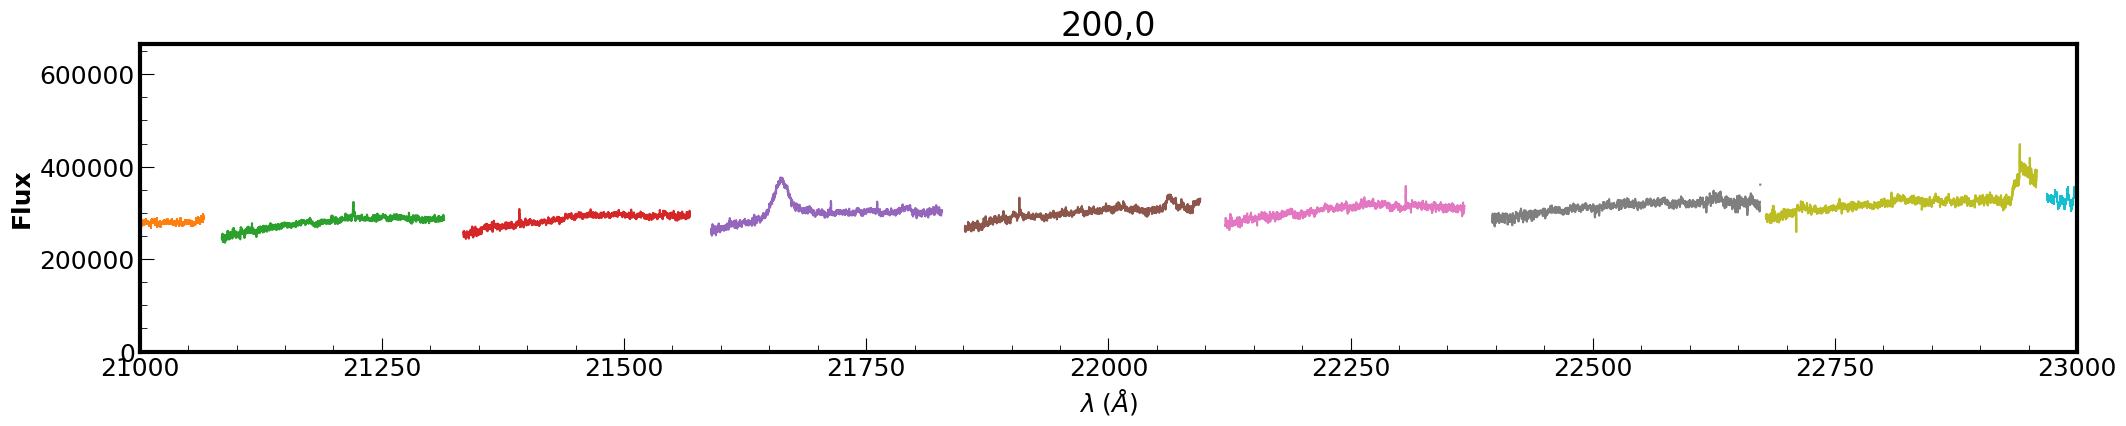

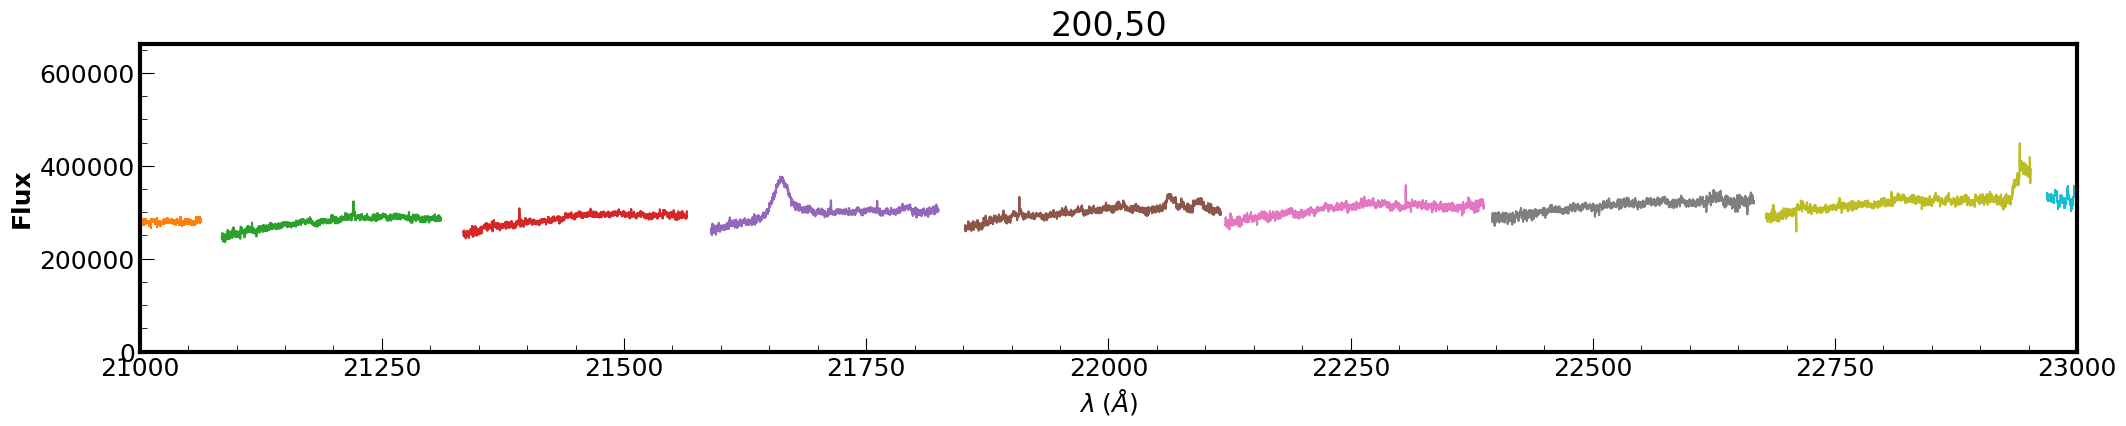

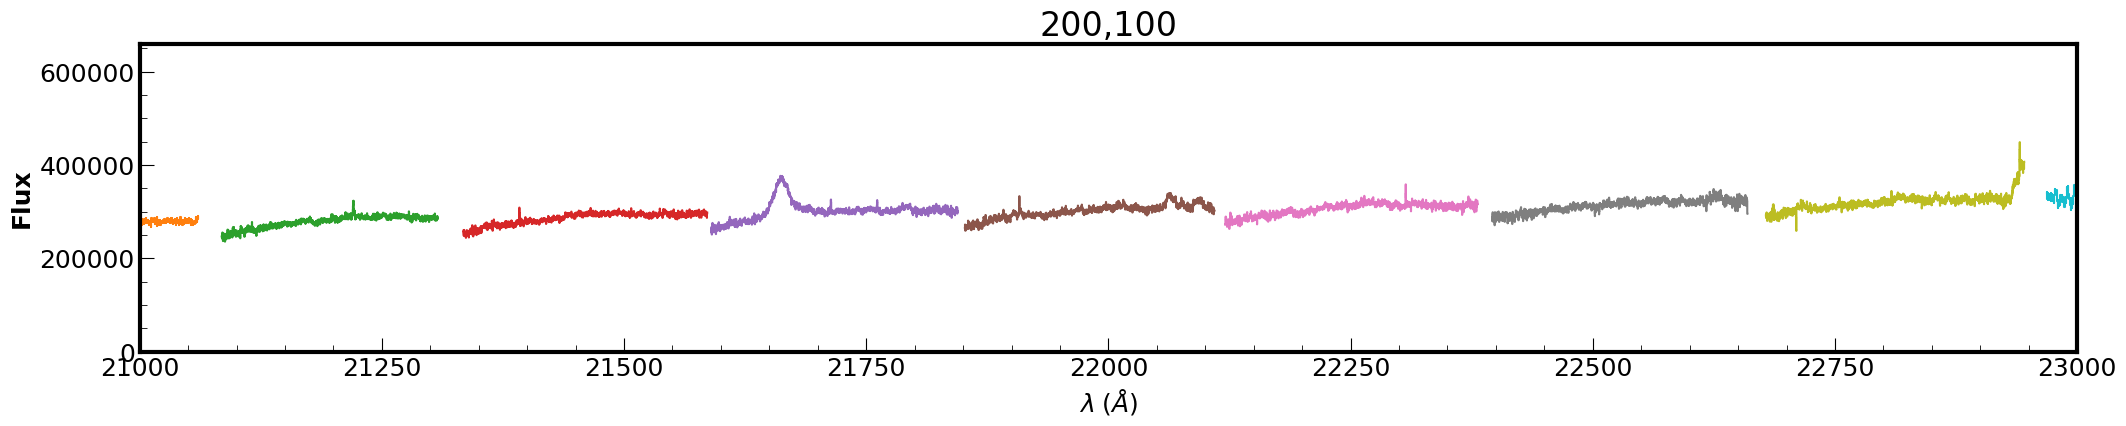

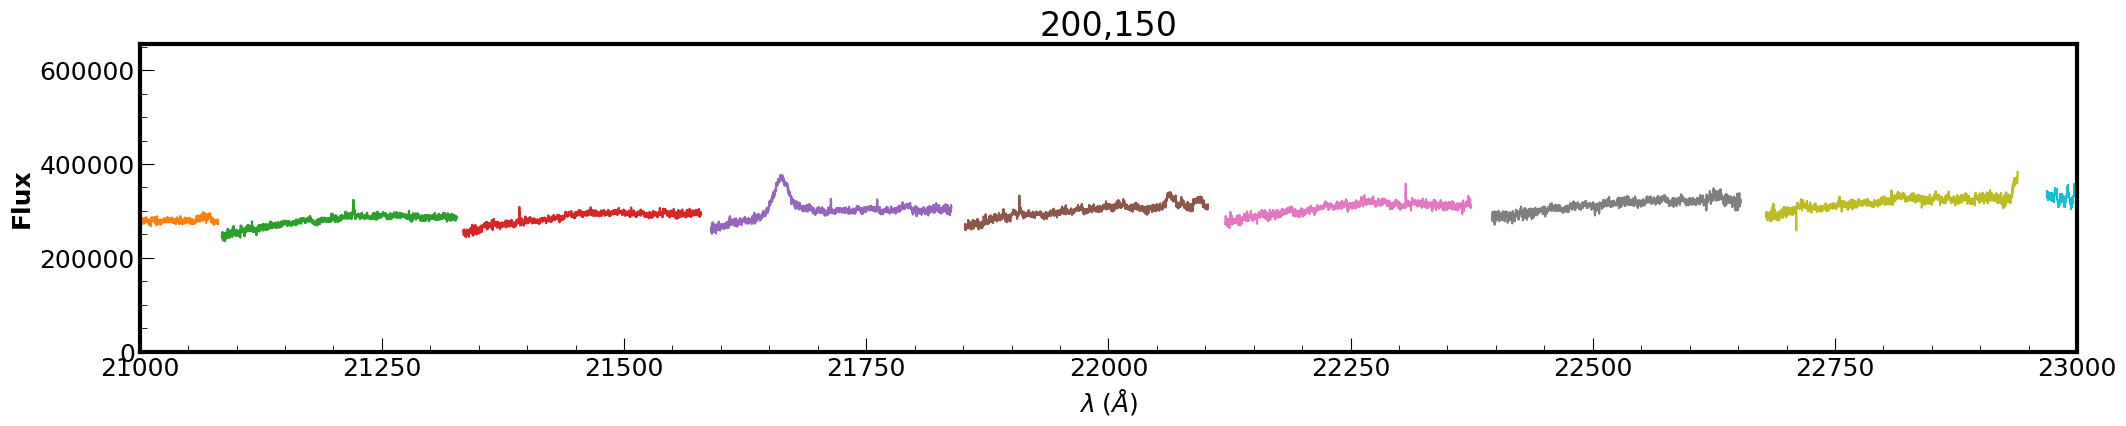

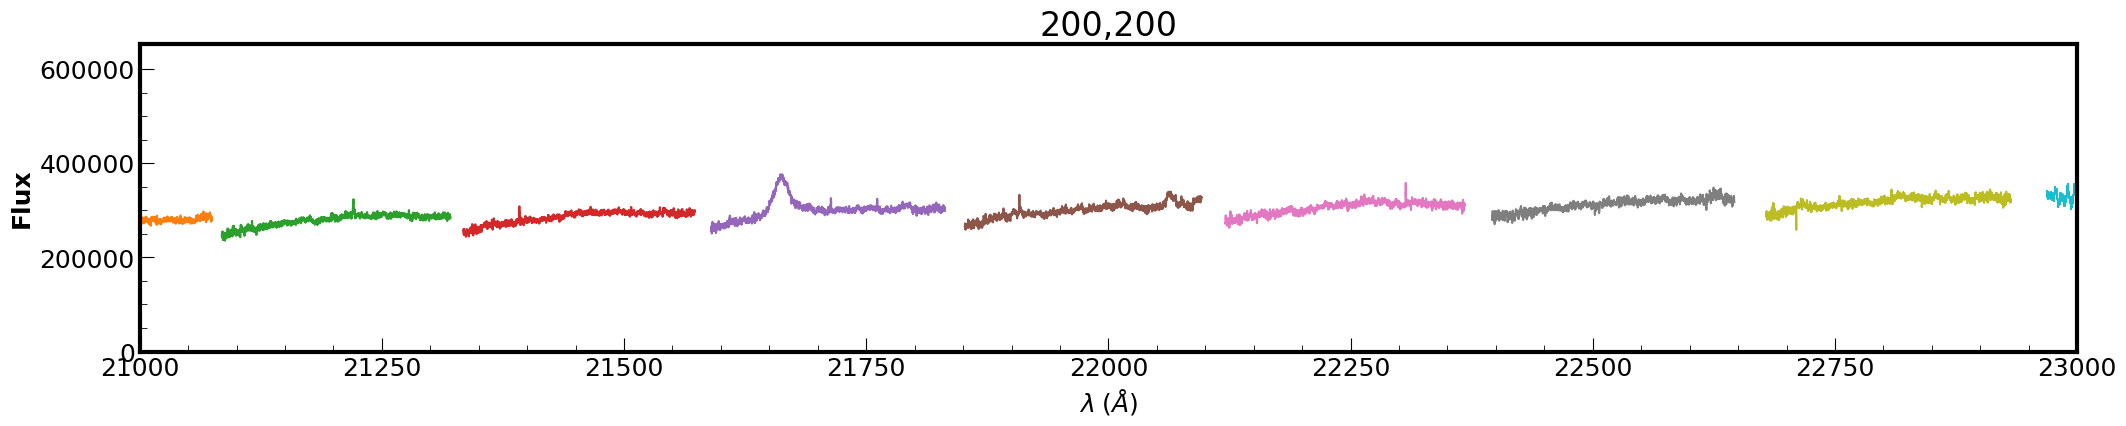

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.14s/it]


In [ ]:
lim_num = np.arange(0,250,50)
# lim_num = [0, 50, 100, 150, 200, 250]

for i in tqdm(range(len(lim_num))):
    for j in range(len(lim_num)):
        spec = IGRINSSpectrumList.read(proto_path[33])\
            .trim_edges(limits=(0+lim_num[i],2048-lim_num[j])).trim_overlap(pivot = 0.5).plot()
        
        plt.title(f"{lim_num[i]},{lim_num[j]}")
        plt.xlim(21000,23000)
        plt.show()

In [6]:
# Directly query NIST to find line features in K-band
with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore') 
    lines_table = Nist.query(2.08*u.um,2.35*u.um,
                    linename = 'Na I, Sc I, Si I, Fe I, Al I, Mg I, Ca I, H I, Ti I',
                    energy_level_unit='eV',output_order='wavelength')

igrins_wav_cut = (lines_table['Observed'] > 2.08) & (lines_table['Observed'] < 2.35)
lines_table = lines_table[igrins_wav_cut]
# lines_table = pd.read_csv('lines_table.txt')

# Make masks for the table of all the lines just in case I want to peek at certain transitions/wavelengths
na1_mask = lines_table['Spectrum'] == 'Na I'
sc1_mask = lines_table['Spectrum'] == 'Sc I'
si1_mask = lines_table['Spectrum'] == 'Si I'
fe1_mask = lines_table['Spectrum'] == 'Fe I'
al1_mask = lines_table['Spectrum'] == 'Al I'
mg1_mask = lines_table['Spectrum'] == 'Mg I'
ca1_mask = lines_table['Spectrum'] == 'Ca I'
h1_mask  = lines_table['Spectrum'] == 'H I'
ti1_mask = lines_table['Spectrum'] == 'Ti I'

# Just add all the masks to a list for the sake of my plotting a few cells down
mask_list = [na1_mask,sc1_mask,si1_mask,fe1_mask,al1_mask,mg1_mask,ca1_mask,h1_mask,ti1_mask]
color_list = ['purple', 'orange', 'green', 'blue', 'brown', 'crimson', 'olive', 'cyan', 'darkgreen']

na_reg_lines = sorted([lines_table[na1_mask][0]['Observed'],
                lines_table[sc1_mask][19]['Observed'],
                lines_table[si1_mask][2]['Observed'],
                lines_table[sc1_mask][20]['Observed'],
                lines_table[na1_mask][1]['Observed']])

na_reg_lines = np.array(na_reg_lines)

ca_reg_lines = list(lines_table[ca1_mask]['Observed'][:]) # list of Ca I lab wavelengths
ca_reg_lines.append(lines_table[fe1_mask]['Observed'][104])
ca_reg_lines = np.array(sorted(ca_reg_lines))

# list of lab wavelengths
ti_reg_lines = np.array([lines_table[ti1_mask]['Observed'][44],
        lines_table[ti1_mask]['Observed'][45],
        lines_table[fe1_mask]['Observed'][85],
        lines_table[fe1_mask]['Observed'][86],
        lines_table[ti1_mask]['Observed'][47]])

mgal_reg_lines = np.array([lines_table[mg1_mask]['Observed'][1],
                        lines_table[mg1_mask]['Observed'][2],
                        lines_table[mg1_mask]['Observed'][3],
                        lines_table[al1_mask]['Observed'][1]])

In [7]:
np.nanargmin(np.abs(wavelen_stack[:,0]-2.2))

7801

In [10]:
# plt.figure(figsize=(25,25))
# for i in range(len(standard_table)):
#     flux_const = (0.5*i)-2.5

#     smooth_flux = savgol_filter(flux_stack[:,i], window_length=51,polyorder=3)
#     med_flux = smooth_flux/np.nanmedian(smooth_flux)

#     plt.plot(wavelen_stack[:,i], med_flux-flux_const,
#              color='seagreen')

#     targ_wav = np.nanmin(wavelen_stack[:,i])
#     textx_idx = np.nanargmin(np.abs(wavelen_stack[:,i]-targ_wav))

#     plt.text(targ_wav-0.011,med_flux[textx_idx]-flux_const,s=f"{standard_table['Spectral_Type'][i]}",
#              fontsize=22, fontweight='bold')

# proto_smooth_flux = savgol_filter(proto_flux_stack[7], window_length=51,polyorder=3)
# proto_med_flux = proto_smooth_flux/np.nanmedian(proto_smooth_flux)
# plt.plot(proto_wavelen_stack[7], proto_med_flux+0.2,
#               color='k',alpha=0.8, label=f"{proto_table['Name'][7]}")

# proto_smooth_flux = savgol_filter(proto_flux_stack[8], window_length=51,polyorder=3)
# proto_med_flux = proto_smooth_flux/np.nanmedian(proto_smooth_flux)
# plt.plot(proto_wavelen_stack[8], proto_med_flux+1.25,
#               color='k',alpha=0.8, label=f"{proto_table['Name'][5]}")

# plt.xlabel(r'Wavelength [$\mu m$]')
# plt.ylabel(r"F$_\lambda$ + Constant")

# # plt.legend()
# plt.show()

In [ ]:
# loop = 0

# plt.figure(figsize=(20,10))
# for i in symp_idxs:
#     flux_const = (0.25*loop)

#     proto_smooth_flux = savgol_filter(proto_flux_stack[i], window_length=101,polyorder=1)
#     med_flux = smooth_flux/np.nanmedian(smooth_flux)

#     proto_med_flux = proto_smooth_flux/np.nanmedian(proto_smooth_flux)

#     plt.plot(proto_wavelen_stack[i], proto_med_flux-flux_const,
#               color='k',alpha=0.8, label=f"{proto_table['Name'][7]}")

#     targ_wav = np.nanmin(proto_wavelen_stack[i])
#     textx_idx = np.nanargmin(np.abs(proto_wavelen_stack[i]-targ_wav))

#     plt.text(2.05, 1.1-flux_const,
#              s=f"{proto_table['Name'][i]}",color='g',fontsize=18, fontweight='bold')
#     loop += 1

# plt.axvline(2.166, 0, 1, color='r',lw=1)
# plt.xlim(2.05)
# plt.xlabel(r'Wavelength [$\mu m$]')
# plt.ylabel(r"F$_\lambda$ + Constant")

# # plt.legend()
# plt.show()

In [ ]:
# # Create a figure with three vertically stacked subplots
# fig, ax = plt.subplots(1, 1, figsize=(25, 15), layout='tight')  # Taller than wide (5x15 inches)

# long_reg = (2.08,2.35)

# # med_norm_flux = []
# # Plot sections of the spectra on each subplot
# # for i in (range(len(standard_table))):
# for i in (range(len(standard_table))):

#     longmask = (wavelen_stack[:,i] > long_reg[0]) & (wavelen_stack[:,i] < long_reg[1])
#     flux_const = (0.5*i)

#     norm_flux = (flux_stack[:, i]/np.nanmedian(flux_stack[:,i]))
#     no_nan = ~np.isnan(norm_flux)
#     norm_flux = norm_flux[no_nan]

#     ax.plot(wavelen_stack[:, i][no_nan], norm_flux + flux_const,
#         color='k', lw=1, alpha=0.5)
    
#     ax.text(s=f"{standard_table['Spectral_Type'].iloc[i]}",
#                 x=np.nanmin(wavelen_stack[:,i][no_nan])-0.012, y=norm_flux[0] + flux_const, size=18,
#                 c='k',fontweight='bold')

#     ax.text(s=f"{standard_table['Name'].iloc[i]}",
#                 x=np.nanmax(wavelen_stack[:,i][no_nan])+0.011, y=norm_flux[-1] + flux_const, size=18,
#                  c='k',fontweight='bold')

# # Plot protostars
# ax.plot(proto_wavelen_stack[1], proto_flux_stack[1]/np.nanmedian(proto_flux_stack[1]),
#         color='green', lw=1, linestyle='--', alpha=1.0, label=f"{proto_table['Name'][1]}")

# ax.plot(proto_wavelen_stack[7], proto_flux_stack[7]/np.nanmedian(proto_flux_stack[7]) + 3.2,
#         color='green', lw=1, linestyle='-', alpha=1.0, label=f"{proto_table['Name'][7]}")

# ax.plot(proto_wavelen_stack[33], proto_flux_stack[33]/np.nanmedian(proto_flux_stack[33]) + 3.,
#         color='green', lw=1, linestyle='-.', alpha=1.0, label=f"{proto_table['Name'][33]}")

# for line in range(len(na_reg_lines)):
#     plt.vlines(na_reg_lines[line], ymin=0.5,ymax=0.75,
#     lw=3,color=f'{color_list[0]}')

# for line in range(len(ti_reg_lines)):
#     plt.vlines(ti_reg_lines[line], ymin=0.5,ymax=0.75,
#     lw=3,color=f'{color_list[1]}')

# for line in range(len(ca_reg_lines)):
#     plt.vlines(ca_reg_lines[line], ymin=0.5,ymax=0.75,
#     lw=3,color=f'{color_list[2]}')

# for line in range(len(mgal_reg_lines)):
#     plt.vlines(mgal_reg_lines[line], ymin=0.5,ymax=0.75,
#     lw=3,color=f'{color_list[4]}')

# ax.set_xlim(left=2.08,right=2.4)
# ax.set_xlabel(r'Wavelength ($\mu m$)')
# ax.set_ylabel('Median Normalized Flux + Constant')

# plt.legend(fontsize=20, bbox_to_anchor=(1,0.5))
# # Show the plot
# plt.show()

# Blackbody + Veiling

$$ 
\begin{align*}
r_k &= F_{cont}/F_* \\
r_k &\simeq \frac{B_\lambda (T_d) \Omega_d}{B_\lambda(T_{eff})\Omega_*}\\
\end{align*}
$$

> $T_d$ = effective dust temperature
> $\Omega_d/\Omega_*$ = solid angle ratio

Greene et al. 2018

Tom's way of explaining it

$$ \alpha = F_{bb}(\lambda_0) / F_\lambda(\lambda_0) $$

$$ \alpha * \frac{B_\lambda(T_{eff}, \lambda)}{B_\lambda(T_{eff}, \lambda_0)}  F_\lambda $$

$$ F_\lambda + \alpha F_\lambda \frac{B_\lambda(T_{eff}, \lambda)}{B_\lambda(T_{eff}, \lambda_0)} $$

In [11]:
def add_bb(wave_arr, flux_arr, t_eff, lam_0, alpha_vals):
    '''
    Input
    ---
    wave_arr = array, wavelength in micron
    flux_arr = array, spectrum flux
    t_eff = float, Effective Temperature for Blackbody function in Kelvin
    lam_0 = float, Lambda_0 in micron wavelength at which to evaluate all this nonsense
    alpha_vals = array-like, a range of alpha values

    Return
    ---
    adjusted_flux_list = list of arrays, each spectrum flux added with blackbody for each alpha
    '''
    blackbody_model = models.BlackBody(temperature=t_eff * u.K)  # Blackbody function (no extinction)
    bb_flux = blackbody_model(wave_arr * u.um)
    
    # Index for target wavelength lam_0
    lam0_idx = np.nanargmin(np.abs(wave_arr - lam_0))
    clean_flux = flux_arr[(~np.isnan(flux_arr)) & (~np.isinf(flux_arr))]
    f_lam0 = flux_arr[lam0_idx]  # Spectrum flux at lam_0

    bb_ratio = bb_flux.value / bb_flux[lam0_idx].value  # Blackbody flux ratio

    # Calculate adjusted flux for each alpha
    adjusted_flux_list = [flux_arr + (alpha * f_lam0 * bb_ratio) for alpha in alpha_vals]

    return adjusted_flux_list  # List of adjusted flux arrays for each alpha

Add blackbody and veiling to flux, smooth and median divide just for a nice plot

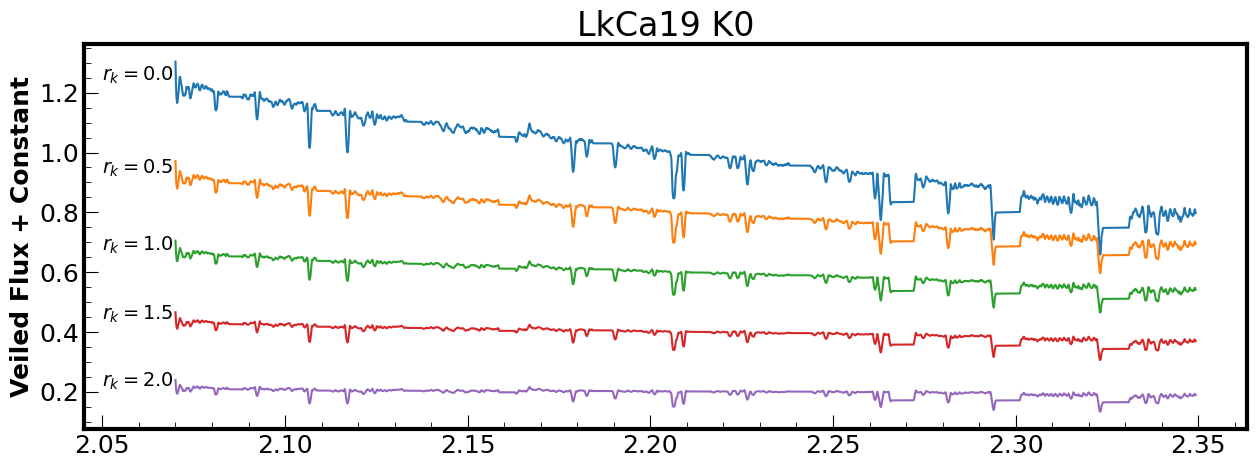

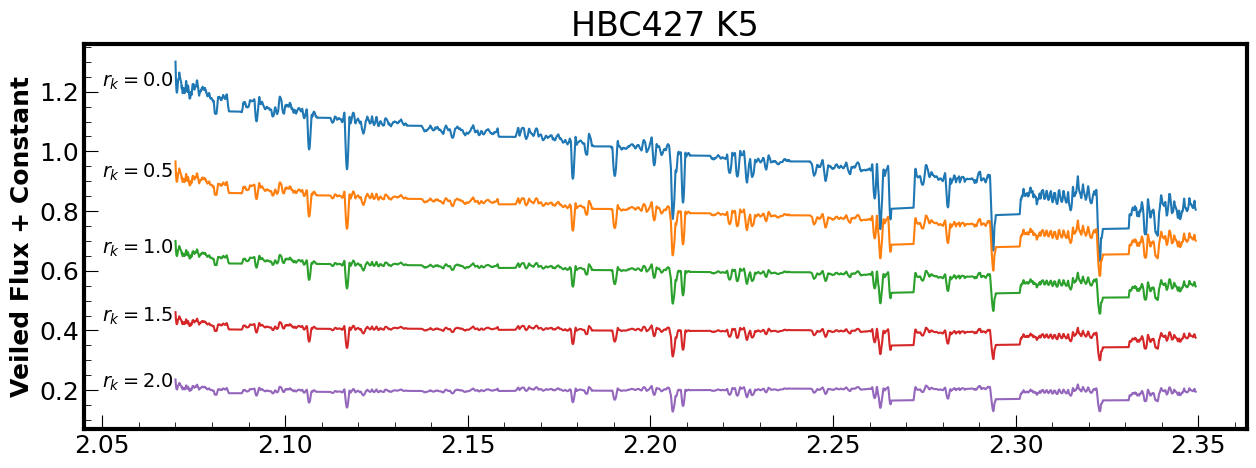

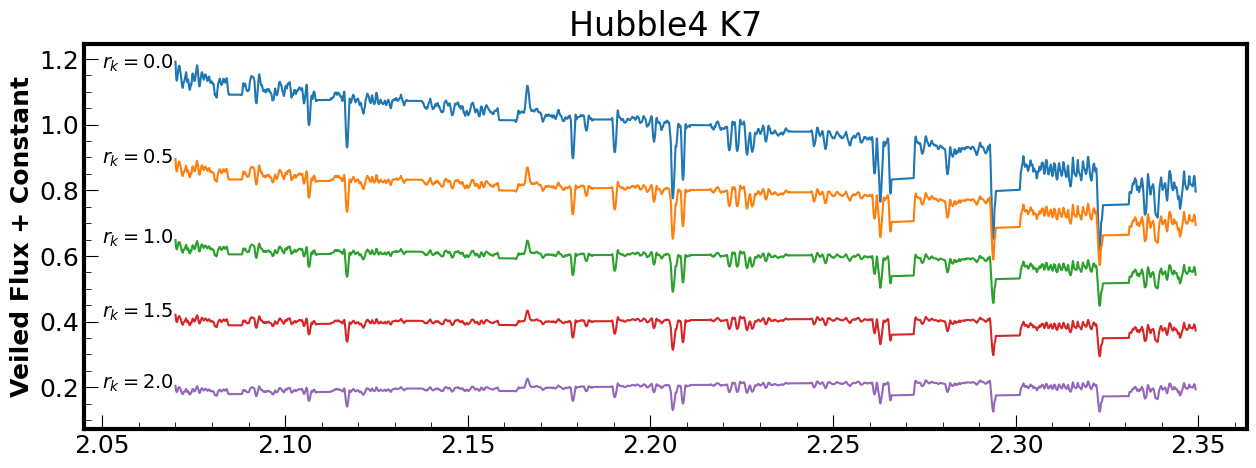

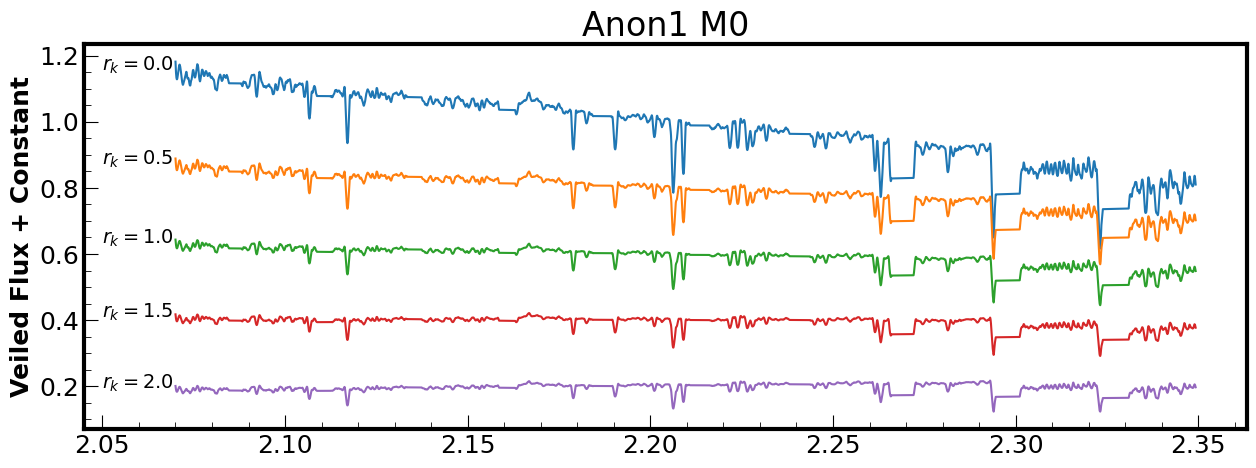

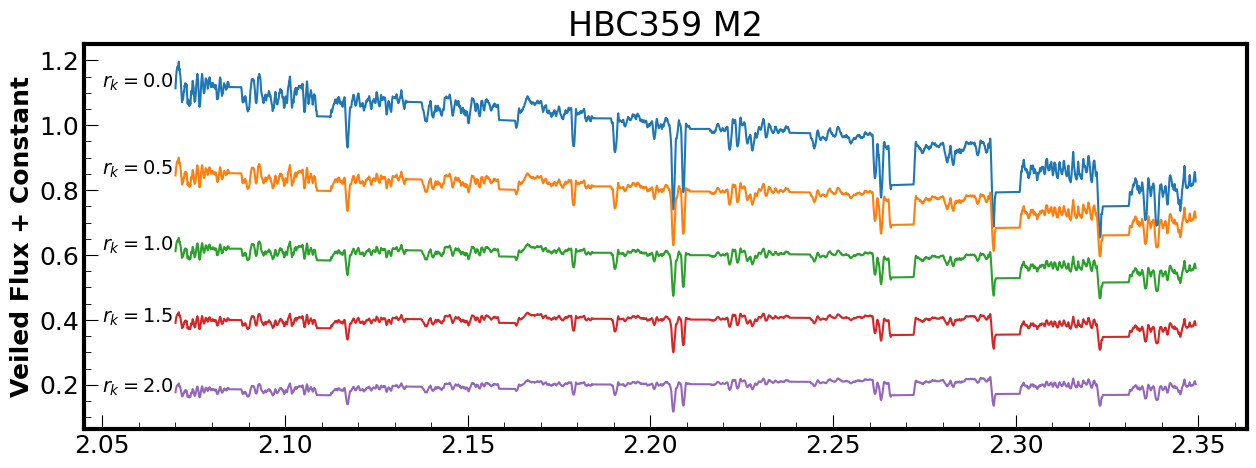

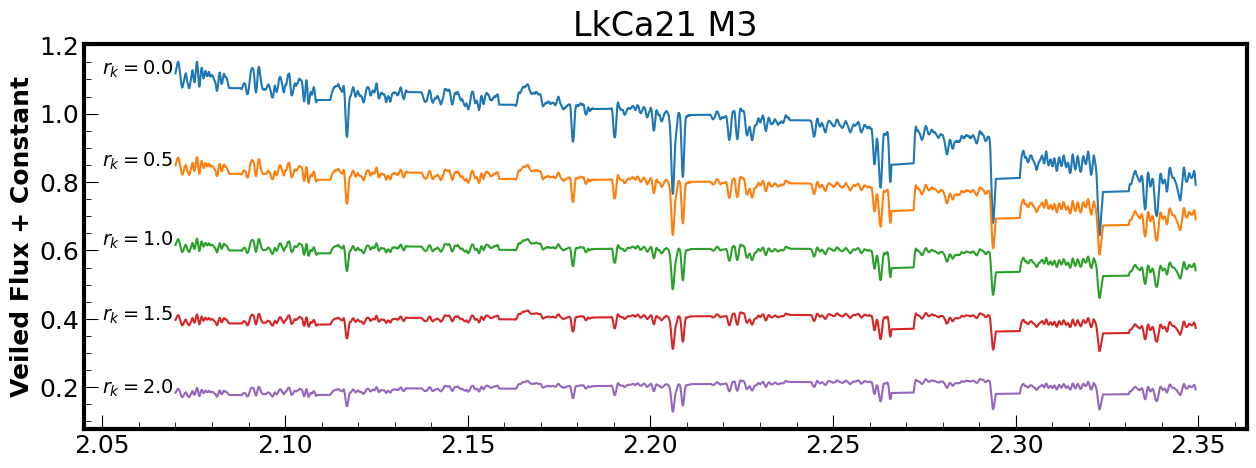

ValueError: All-NaN slice encountered

In [12]:
rk_arr = np.arange(0,2.5,0.5) # array of veiling r_K

for n in range(len(standard_table)):
    # Adjust window_length based on n
    if n > 2:  # Replace threshold_value with the index after which you want a different window length
        window_length = 11  # Adjusted window length
    else:
        window_length = 11  # Original window length

    adj_fluxes = add_bb(wavelen_stack[:,n], flux_stack[:,n], 1500, 2.2, rk_arr)
    for i in range(len(adj_fluxes)):
        flux_const = (0.2*i)
        
        med_adj_fluxes = adj_fluxes[i]/np.nanmedian(adj_fluxes[i])
        
        plt.plot(wavelen_stack[:,n], savgol_filter(med_adj_fluxes-flux_const,window_length=101,polyorder=3))
        plt.text(np.nanmin(wavelen_stack[:,n])-0.02, (med_adj_fluxes-flux_const)[0],s=rf"$r_k=${rk_arr[i]}",fontsize=14)

    #np.nanmin(wavelen_stack[:,n])-0.005
    plt.xlim(np.nanmin(wavelen_stack[:,n]-0.025))
    # plt.ylim(top=1.7)
    plt.ylabel('Veiled Flux + Constant')

    plt.title(f"{standard_table['Name'][n]} {standard_table['Spectral_Type'][n]}")

    plt.show()